In [1]:
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import cv2
import kagglehub

2025-06-19 09:31:29.644388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750325489.815807      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750325489.869094      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = kagglehub.dataset_download("nareshlankalapalli/paddy-disease")

Mounting files to /kaggle/input/paddy-disease...


In [3]:
import os
import shutil

# Step 1: Copy test folder to working directory
src = '/kaggle/input/paddy-disease/rice_disease_data/test'
dst = '/kaggle/working/rice_disease_data/test_fixed1'

# Copy directory tree
shutil.copytree(src, dst)

# Step 2: Rename inside working directory
rename_map = {
    'Neck_Blast': 'neck_blast',
    'Rice Hispa': 'rice_hispa',
    'Sheath Blight': 'sheath_blight',
    'Tungro': 'tungro'
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(dst, old_name)
    new_path = os.path.join(dst, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} ➝ {new_name}")
    else:
        print(f"Folder not found: {old_name}")


Renamed: Neck_Blast ➝ neck_blast
Renamed: Rice Hispa ➝ rice_hispa
Renamed: Sheath Blight ➝ sheath_blight
Renamed: Tungro ➝ tungro


In [12]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = 224  # or your preferred size
batch_size = 40
train_dir = '/kaggle/input/paddy-disease/rice_disease_data/train'
test_dir = '/kaggle/working/rice_disease_data/test_fixed1'

# Create training and validation ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'  # Subset for validation
)

# Testing generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
    
)

Found 11607 images belonging to 10 classes.
Found 2899 images belonging to 10 classes.
Found 3500 images belonging to 10 classes.


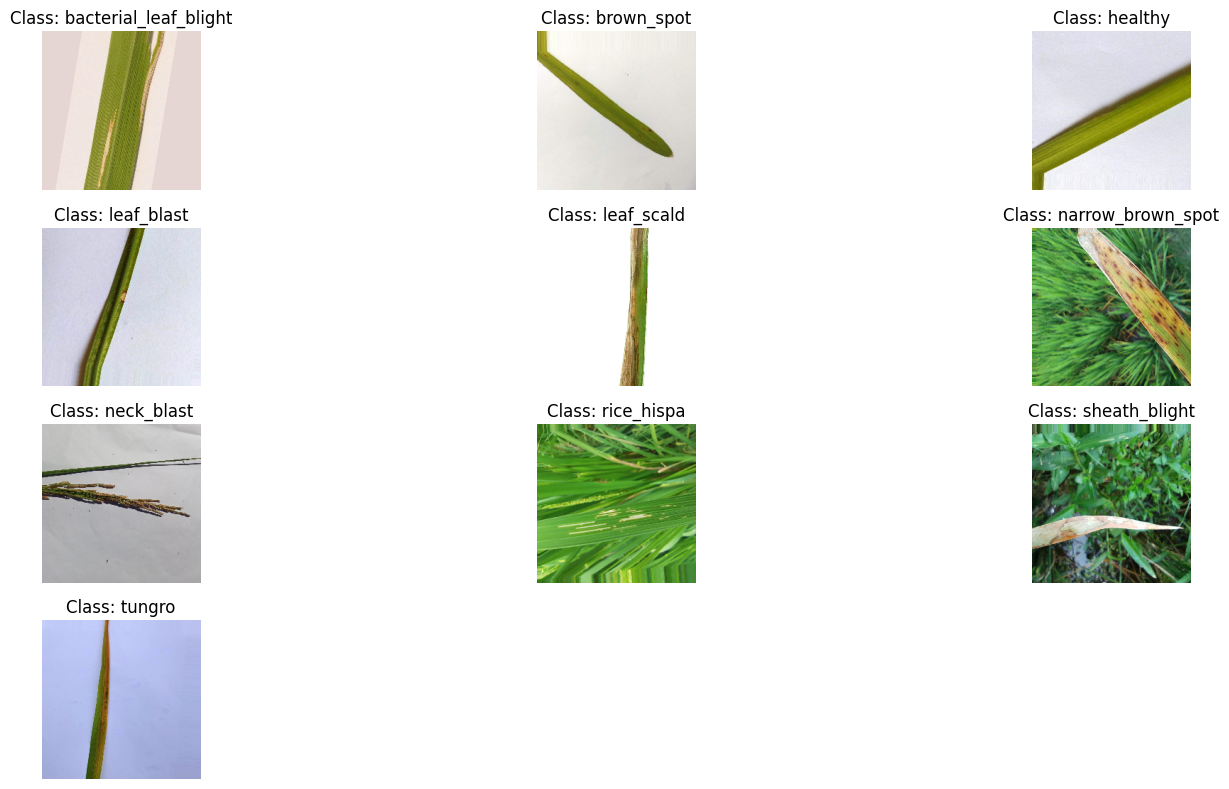

In [5]:
import random
# Automatically get class folder names
class_names= ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']

# Plot one random image from each class folder
plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    if not image_files:
        print(f"No images found in {class_name}")
        continue

    # Randomly select one image
    selected_image = random.choice(image_files)
    img_path = os.path.join(class_path, selected_image)
    img = load_img(img_path, target_size=(img_size,img_size,3))

    plt.subplot(4, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm
import shutil

# PARAMETERS
dataset_path =test_dir
target_size = 224
TARGET_IMAGES = 350

# Data augmenter
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)

    print(f"\n🔍 Class '{class_name}': {current_count} images")

    # ----------- CASE 1: Downsample if more than needed -----------
    if current_count > TARGET_IMAGES:
        print(f"⚠️ Too many images. Downsampling to {TARGET_IMAGES}...")
        random.shuffle(image_files)
        keep_files = image_files[:TARGET_IMAGES]
        delete_files = set(image_files) - set(keep_files)

        for file_name in delete_files:
            try:
                os.remove(os.path.join(class_path, file_name))
            except Exception as e:
                print(f"Error deleting {file_name}: {e}")
        print(f"✅ Downsampled '{class_name}' to {TARGET_IMAGES} images.")

    # ----------- CASE 2: Augment if fewer than needed -----------
    elif current_count < TARGET_IMAGES:
        needed = TARGET_IMAGES - current_count
        print(f"🔄 Generating {needed} new images...")

        i = 0
        pbar = tqdm(total=needed, desc=f"Augmenting '{class_name}'")
        while i < needed:
            for img_name in image_files:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(target_size, target_size))
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)

                    aug_iter = augmenter.flow(x, batch_size=1)
                    aug_img = next(aug_iter)[0].astype(np.uint8)

                    save_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(class_path, save_name)
                    save_img(save_path, aug_img)

                    i += 1
                    pbar.update(1)

                    if i >= needed:
                        break
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")
                    continue
        pbar.close()
        print(f"✅ Augmentation complete for class '{class_name}'.")

    # ----------- CASE 3: Already balanced -----------
    else:
        print("✅ Already has exactly 350 images. Skipping.")



🔍 Class 'narrow_brown_spot': 382 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'narrow_brown_spot' to 350 images.

🔍 Class 'brown_spot': 380 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'brown_spot' to 350 images.

🔍 Class 'bacterial_leaf_blight': 376 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'bacterial_leaf_blight' to 350 images.

🔍 Class 'healthy': 391 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'healthy' to 350 images.

🔍 Class 'tungro': 310 images
🔄 Generating 40 new images...


Augmenting 'tungro': 100%|██████████| 40/40 [00:00<00:00, 65.50it/s]


✅ Augmentation complete for class 'tungro'.

🔍 Class 'rice_hispa': 225 images
🔄 Generating 125 new images...


Augmenting 'rice_hispa': 100%|██████████| 125/125 [00:03<00:00, 35.74it/s]


✅ Augmentation complete for class 'rice_hispa'.

🔍 Class 'neck_blast': 322 images
🔄 Generating 28 new images...


Augmenting 'neck_blast': 100%|██████████| 28/28 [00:01<00:00, 16.28it/s]


✅ Augmentation complete for class 'neck_blast'.

🔍 Class 'leaf_blast': 362 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_blast' to 350 images.

🔍 Class 'leaf_scald': 386 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_scald' to 350 images.

🔍 Class 'sheath_blight': 288 images
🔄 Generating 62 new images...


Augmenting 'sheath_blight': 100%|██████████| 62/62 [00:01<00:00, 31.25it/s]

✅ Augmentation complete for class 'sheath_blight'.


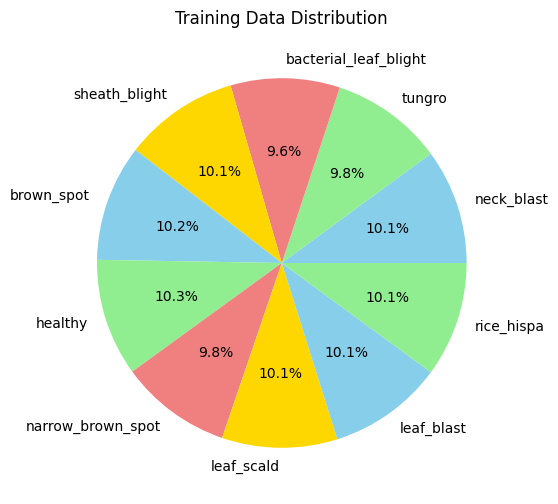

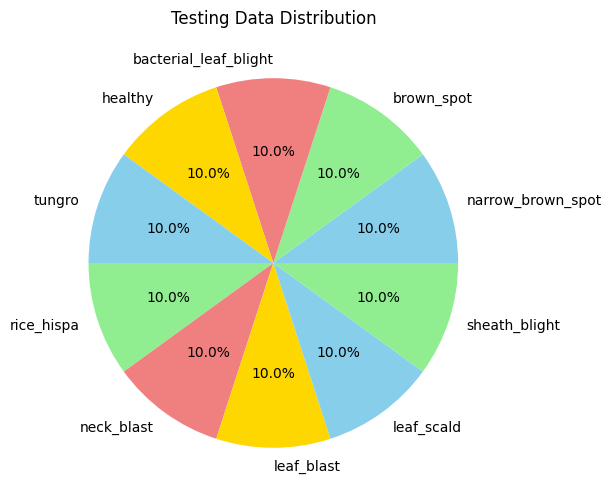

Training Data Counts:
neck_blast: 1461 images
tungro: 1428 images
bacterial_leaf_blight: 1386 images
sheath_blight: 1458 images
brown_spot: 1480 images
healthy: 1491 images
narrow_brown_spot: 1416 images
leaf_scald: 1465 images
leaf_blast: 1460 images
rice_hispa: 1461 images

Testing Data Counts:
narrow_brown_spot: 350 images
brown_spot: 350 images
bacterial_leaf_blight: 350 images
healthy: 350 images
tungro: 350 images
rice_hispa: 350 images
neck_blast: 350 images
leaf_blast: 350 images
leaf_scald: 350 images
sheath_blight: 350 images


In [7]:
# Function to count images in each class
def count_images(dataset_path):
    class_counts = {}
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            class_counts[label] = num_images
    return class_counts

# Count images in training and testing datasets
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Plot pie charts
def plot_pie_chart(class_counts, title):
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title(title)
    plt.show()

# Plot for training data
plot_pie_chart(train_counts, "Training Data Distribution")

# Plot for testing data
plot_pie_chart(test_counts, "Testing Data Distribution")

# Print the number of images in each class
print("Training Data Counts:")
for label, count in train_counts.items():
    print(f"{label}: {count} images")

print("\nTesting Data Counts:")
for label, count in test_counts.items():
    print(f"{label}: {count} images")

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.layers import  BatchNormalization, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.initializers import HeNormal

# Define model
model = Sequential()
initializer = HeNormal()
img_size = 224
input_shape = (img_size, img_size, 3)

# First Conv Block
model.add(Convolution2D(32, (3, 3), padding='same', kernel_initializer=initializer, input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Conv Block
model.add(Convolution2D(64, (3, 3), padding='same', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Conv Block
model.add(Convolution2D(128, (3, 3), padding='same', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Conv Block
model.add(Convolution2D(256, (3, 3), padding='same', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling instead of Flatten
model.add(Flatten())

# Dense Layers
model.add(Dense(512, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(256, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(10, activation='softmax'))

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750325619.152872      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 26,217,930 (100.01 MB)

 Trainable params: 26,215,434 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

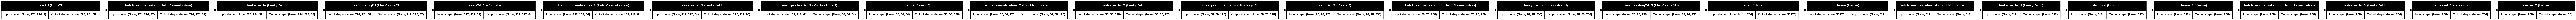

In [9]:
# Save visual block diagram
plot_model(model, to_file='paddy_leaf_cnn_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Display block diagram
try:
    display(Image(filename='paddy_leaf_cnn_model.png'))
except:
    print("Model plot saved as 'paddy_leaf_cnn_model.png'")

In [10]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-5) 
# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator ,
    validation_steps=validation_generator .samples //validation_generator .batch_size,
    verbose=1
)

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 283s 977ms/step - accuracy: 0.4461 - loss: 1.6914 - val_accuracy: 0.4497 - val_loss: 1.5409
Epoch 2/50
  1/290 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.6000 - loss: 1.2762

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


290/290 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.6000 - loss: 1.2762 - val_accuracy: 0.4507 - val_loss: 1.5383
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 214s 739ms/step - accuracy: 0.6781 - loss: 1.0029 - val_accuracy: 0.7431 - val_loss: 0.7790
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.6500 - loss: 1.1034 - val_accuracy: 0.7424 - val_loss: 0.7804
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 206s 712ms/step - accuracy: 0.7234 - loss: 0.8485 - val_accuracy: 0.7951 - val_loss: 0.6563
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 42s 144ms/step - accuracy: 0.7000 - loss: 0.8529 - val_accuracy: 0.7969 - val_loss: 0.6527
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 228s 786ms/step - accuracy: 0.7585 - loss: 0.7507 - val_accuracy: 0.8052 - val_loss: 0.6008
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.7500 - loss: 0.6332 - val_accuracy: 0.8062 - val_loss: 0.6023
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 199s 686ms/step - accuracy: 0.7933 - loss: 0.6371 -

In [14]:
model.save("/kaggle/working/paddy_basiccnn251_leaf_disease_model.h5")

In [15]:
# Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss:     {val_loss:.4f}")


Training Accuracy:   97.50%
Training Loss:       0.0654
Validation Accuracy: 88.13%
Validation Loss:     0.3546


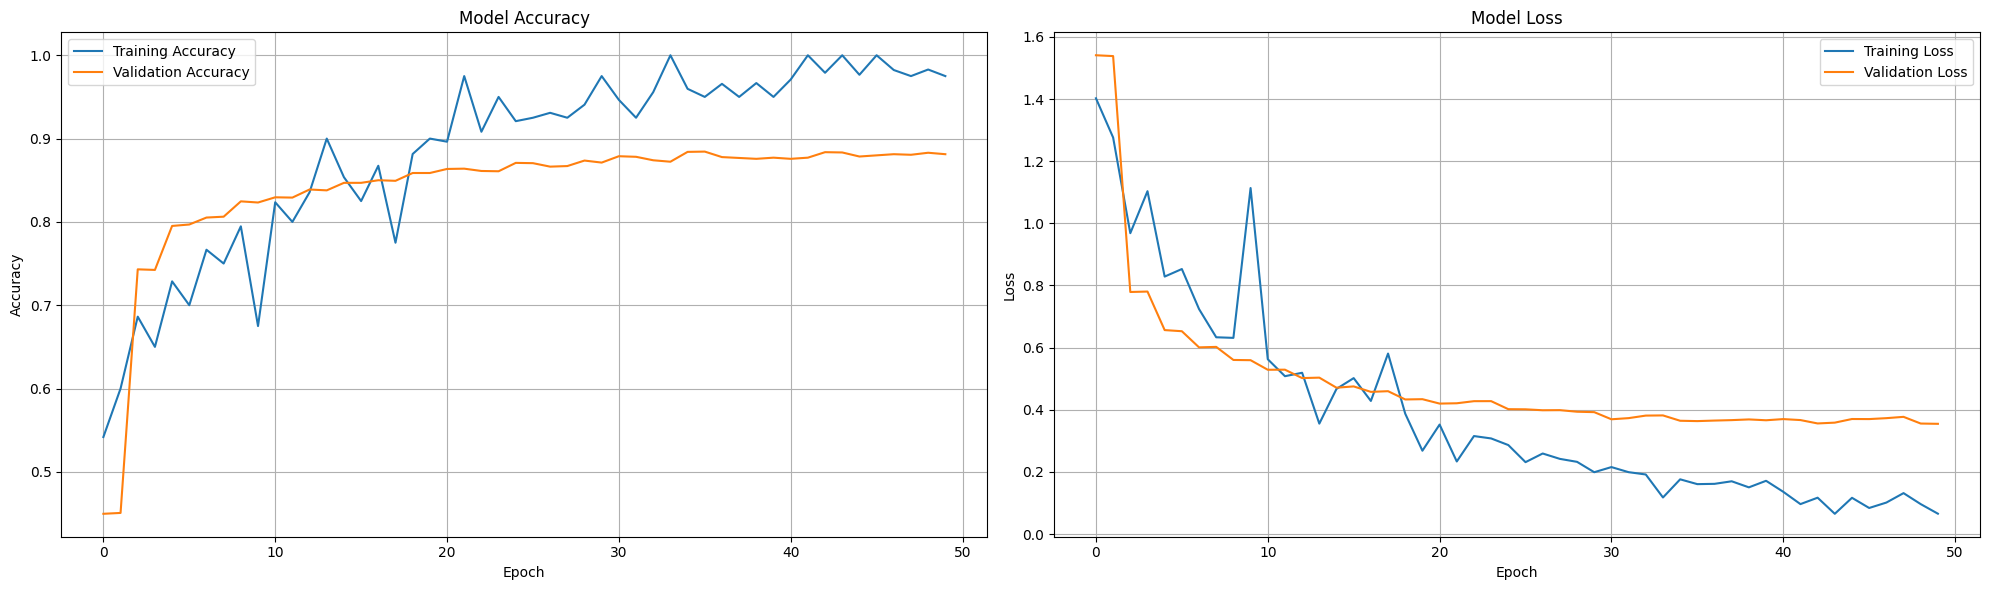

In [16]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(20,6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [17]:
correct = 0
total = 0

for i in range(len(test_generator)):
    try:
        x, y_true = test_generator[i]
        y_pred = model.predict(x)
        correct += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        total += x.shape[0]
    except Exception as e:
        print(f"Skipping batch {i} due to error: {e}")

print(f"Test Accuracy: {(correct / total) * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━

Found 11607 images belonging to 10 classes.
Found 2899 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 571ms/step


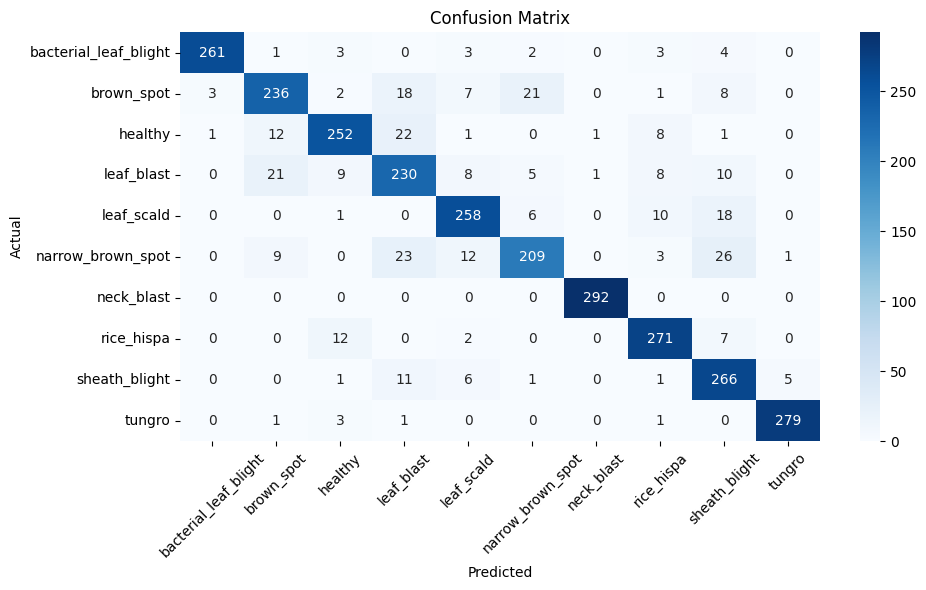


Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.94      0.96       277
           brown_spot       0.84      0.80      0.82       296
              healthy       0.89      0.85      0.87       298
           leaf_blast       0.75      0.79      0.77       292
           leaf_scald       0.87      0.88      0.87       293
    narrow_brown_spot       0.86      0.74      0.79       283
           neck_blast       0.99      1.00      1.00       292
           rice_hispa       0.89      0.93      0.91       292
        sheath_blight       0.78      0.91      0.84       291
               tungro       0.98      0.98      0.98       285

             accuracy                           0.88      2899
            macro avg       0.88      0.88      0.88      2899
         weighted avg       0.88      0.88      0.88      2899



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Ensure validation_generator is not shuffled ---
# If not already done earlier, re-define it here with shuffle=False
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)
# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation' ,
    shuffle=False
)

# --- Get true labels from validation set ---
Y_true = validation_generator.classes

# --- Predict class probabilities using the trained model ---
# Cast the result of np.ceil to an integer for the 'steps' argument
Y_pred_probs = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size)))

# --- Get predicted class indices ---
Y_pred = np.argmax(Y_pred_probs, axis=1)

# --- Get class names ---
class_names = list(validation_generator.class_indices.keys())

# --- Generate the confusion matrix ---
cm = confusion_matrix(Y_true, Y_pred)

# --- Plot the confusion matrix ---
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Print classification report ---
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_names))